# Text Preprocesing



## Installing Dependency


In [ ]:
!pip install emoji
!pip install symspellpy
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_lg

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)
Requirement already up-to-date: spacy-lookups-data in /usr/local/lib/python3.6/dist-packages (0.3.2)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import numpy as np 
import emoji
import nltk
from pathlib import Path
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from symspellpy import SymSpell, Verbosity
# text preprocessing
from nltk.tokenize import word_tokenize
import pkg_resources
import re, string, json
import spacy
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
seed=10
tf.random.set_seed(seed)

## DATA EXPLORATORY & CLEANING

Objective is to make the data as error-free as possible for the model to train on.
- explore the data, print out the statistics to understand the dataset composition
- Identify characters that do not contain information and does not facilitate in model training 
<br>(e.g. special symbols, special character, wrong punctuation, werid numbers, wrong spelling)
- Remove or fill empty rows with default values
- convert the dataset to lower- cased. 

### Data Exploratory

In [ ]:
#reading data from csv file
df = pd.read_csv("text_emotion.csv", engine = 'python')

#print out the stats of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
#show first 5 of the dataset
df.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [ ]:
#explore what are the unique sentiments that is within the dataset
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
#explore what are the unique author/username that is within the dataset
len(df['author'].unique())

33871

In [ ]:
#explore what are the unique content that is within the dataset (checking for duplicates)
len(df['content'].unique())

39827

In [ ]:
#check for duplication
duplicated = df[df.duplicated(['content','sentiment'])]
duplicated.head(10)

,tweet_id,sentiment,author,content
521,1957088574,worry,Chassidy7,Somebody please save the polar bears!
6591,1961366316,sadness,Zoraida1980,Headache
8878,1962332251,worry,letsdomusiccc,My throat hurts
10918,1963057544,worry,CoopInSoCal,@ericbolling Where's Dani Babb?
12531,1963597385,sadness,laurenc3191,not feeling too great today
15728,1964969733,sadness,Nickiitah,I miss you
15988,1965087416,neutral,BETTERIDGE6,going to work
17457,1965667672,neutral,Jazze820,cleaning my room
18130,1965893112,worry,EmperorCommodus,i have a headache
18472,1965978796,worry,Sw3eTiE,My back hurts


In [ ]:
#show the number of unique content within each sentiments to check if there is data imbalance in each group 
data =df.drop_duplicates(subset=['content', 'sentiment'])
sentiment_count= data['sentiment'].value_counts(sort=False)
sentiment_count


surprise      2187
neutral       8617
empty          827
relief        1524
hate          1323
anger          110
fun           1776
worry         8452
happiness     5194
boredom        179
love          3801
enthusiasm     759
sadness       5160
Name: sentiment, dtype: int64

### Plot statistics of data to understand the dataset composition 
- see number of classes and samples in each class to spot any data imbalance, therefore we will be adding additional dataset from https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp to balance out the emotions
- We will be trimming the dataset to only 6 basic emotions

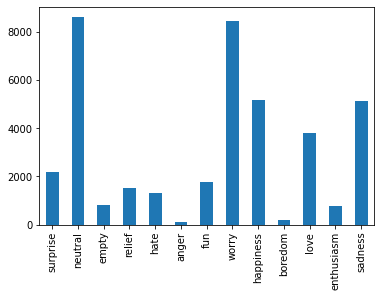

In [ ]:
sentiment_count.plot.bar()

### Data cleaning 
- Remove any empty rows if any as it does not hold any value to text emotion recognition
- Normalise text datanase into lower case as un-cased characters are regarded differently by computers as different words
- -If info between the cased and un-cased chars needs to be used e.g. Named Entity Recognition (NER) task where words starting with capital letters are named entities in NER, leave the dataset as- is with case chars intact.

In [ ]:
emotion_train_df = pd.read_csv('train.txt', header =None, sep =';', names = ['content','sentiment'], encoding='utf-8')
emotion_test_df = pd.read_csv('test.txt', header = None, sep =';', names = ['content','sentiment'],encoding='utf-8')
emotion_val_df = pd.read_csv('val.txt', header = None, sep =';', names = ['content','sentiment'],encoding='utf-8')

In [ ]:
emotion_train_df.info()
print('\n')
emotion_val_df.info()
print('\n')
emotion_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    16000 non-null  object
 1   sentiment  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2000 non-null   object
 1   sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2000 non-null   object
 1   sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [ ]:
frame = [emotion_test_df, emotion_train_df, emotion_val_df]
new_emotion_df = pd.concat(frame)
new_emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [ ]:
new_emotion_df['sentiment'].value_counts(sort=False)

surprise     719
joy         6761
love        1641
fear        2373
anger       2709
sadness     5797
Name: sentiment, dtype: int64

In [ ]:
new_emotion_df['sentiment']= new_emotion_df['sentiment'].replace(['joy'], 'happiness')
new_emotion_df['sentiment'].value_counts(sort=False)

surprise      719
love         1641
fear         2373
anger        2709
happiness    6761
sadness      5797
Name: sentiment, dtype: int64

In [ ]:
# trimming of dataset to only sentiment and content
crowdflower_df = data[['content', 'sentiment']]
crowdflower_df.head()



,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [ ]:
# display the general info of the cleaned dataset
crowdflower_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39909 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    39909 non-null  object
 1   sentiment  39909 non-null  object
dtypes: object(2)
memory usage: 935.4+ KB


In [ ]:
crowdflower_df['sentiment']= crowdflower_df['sentiment'].replace(['hate'], 'anger')
crowdflower_df['sentiment'] = crowdflower_df['sentiment'].replace(['worry'], 'fear')
crowdflower_df['sentiment'].value_counts(sort=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


surprise      2187
neutral       8617
empty          827
relief        1524
fear          8452
anger         1433
fun           1776
happiness     5194
boredom        179
love          3801
enthusiasm     759
sadness       5160
Name: sentiment, dtype: int64

In [ ]:
combine_frame = [crowdflower_df, new_emotion_df]
combined_df = pd.concat(combine_frame)
combined_df['sentiment'].value_counts(sort = False)

surprise       2906
neutral        8617
anger          4142
fun            1776
happiness     11955
love           5442
enthusiasm      759
sadness       10957
empty           827
relief         1524
fear          10825
boredom         179
Name: sentiment, dtype: int64

In [ ]:
combined_df[combined_df.sentiment == 'anger']

,content,sentiment
30,It is so annoying when she starts typing on he...,anger
86,dammit! hulu desktop has totally screwed up my...,anger
99,@ cayogial i wanted to come to BZ this summer ...,anger
101,@mrgenius23 You win ... SIGH Rakeem,anger
105,"@soviet_star Damn, that sucks",anger
...,...,...
1982,i feel like the world is just being bitter and...,anger
1983,i see people who have accomplished so much mor...,anger
1985,i started to see a concerning pattern i d rush...,anger
1993,i feel so tortured by it,anger


In [ ]:
# trimming of dataset to only 7 major emotions.
#sadness, anger, love, happiness, surprise, fear ,neutral
dataframes = (combined_df[combined_df.sentiment == 'sadness'], combined_df[combined_df.sentiment == 'anger'], combined_df[combined_df.sentiment == 'love'], combined_df[combined_df.sentiment == 'happiness'], combined_df[combined_df.sentiment == 'surprise'], combined_df[combined_df.sentiment == 'fear'], combined_df[combined_df.sentiment == 'neutral'])
trimmed_dataset = pd.concat(dataframes)
trimmed_dataset['sentiment'].value_counts(sort = False)

surprise      2906
neutral       8617
anger         4142
happiness    11955
love          5442
sadness      10957
fear         10825
Name: sentiment, dtype: int64

In [ ]:
def build_vocabulary(texts):
    """
    input: list of list of words
    output: dictionary of words and their count
    """
    print('build vocabulary')
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

import operator
def check_coverage(vocab, embeddings_index):
    '''
    input: vocabulary, embedding index
    output: list of unknown words; also prints the vocabulary coverage of embeddings and the % of comments text covered by the embeddings
    '''
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in tqdm(vocab.keys()):
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print('Found embeddings for {:.3%} of vocabulary'.format(len(known_words)/len(vocab)))
    print('Found embeddings for {:.3%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

#### Remove any duplicates of white space, punctuations and URLs:
This is done via a simple regex replace. By doing regex cleaning we will not have multiple sizes of reticence and exclamation point markings. Additionally, the removal of URL will reduce the number of distinct tokens that we have during tokenisation later

**Note: `_replace_urls` is used before `clean_punctuation` to prevent replacement of complex punctuations use within urls.**



In [ ]:
def clean_regex(sentence_list):
    corrected_sentence_list = []
    print("Normalizing whitespaces and punctuation")
    for sentence in tqdm(sentence_list):
        _text = _replace_urls(sentence)
        _text = _clean_punctuation(_text)
        _text = _normalize_whitespace(_text)
        corrected_sentence_list.append(_text)
    return corrected_sentence_list

#replace any URLs with a <URL> tag
def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

# Simplifies doubled or more complex punctuation with the exception of '...'
def _clean_punctuation(text):
  
    sentence = str(text)
    #sentence = re.sub(r'[^A-Za-z0-9(),!;?\'\`\"]1+', r'\1', sentence)
    sentence = re.sub(r'([!?,;])\1+', r'\1', sentence)
    sentence = re.sub(r'\.{2,}', r'...', sentence)
    #sentence = re.sub(r"\s{2,}", ' ', sentence)
    sentence = sentence.strip()
    return sentence

# Normalizes whitespaces by removing duplicates
def _normalize_whitespace(text):
  
    sentence = str(text)
    sentence = re.sub(r"//t",r"\t", sentence)
    sentence = re.sub(r"( )\1+",r"\1", sentence)
    sentence = re.sub(r"(\n)\1+",r"\1", sentence)
    sentence = re.sub(r"(\r)\1+",r"\1", sentence)
    sentence = re.sub(r"(\t)\1+",r"\1", sentence)
    return sentence.strip(" ")
    

#### Substitution of contractions:
As data is from social media, slang and  contraction are commonly used. By using
a list of contractions from Wikipedia, we loop through the sentences and replace the contractions for their actual words. This allow for better sentence structuring for tokenization. 

In [ ]:
def replace_contractions_abbervations(sentence_list):
    contraction_list = json.loads(open('english_contractions.json', 'r').read())
    abbervation_list = json.loads(open('abbervations.json', 'r').read())
    corrected_sentence_list = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        corrected_sentence = _normalize_contractions_text(sentence, contraction_list)
        corrected_sentence_list.append(_normalize_abbervations_text(corrected_sentence, abbervation_list))
    return corrected_sentence_list

# replace english contractions with actual words
def _normalize_contractions_text(text, contractions):
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

# replace abbervations with actual words
def _normalize_abbervations_text(text, abbervations):
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in abbervations:
            replacement = abbervations[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

#### Spell Correction:
Given that most spelling correcting dictionaries lack important contextual words, so consider slangs as misspells. Spelling correction is tricky as it may cauuse unwanted changes.

However, i decided to use `symspellpy` for spelling correction due to its computational efficiency. An alternatice approach is through a deep learning model to do spelling correction based on context e.g. Word2Vect


In [ ]:
def spelling_correction(sentence_list):
    max_edit_distance_dictionary= 3
    prefix_length = 4
    spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)
    corrected_sentence_list = []
    print("Spell correcting")
    for sentence in tqdm(sentence_list):
        corrected_sentence_list.append(_spelling_correction_text(sentence, spellchecker))
    return corrected_sentence_list


# Spelling correction is done via pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
def _spelling_correction_text(text, spellchecker):

    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

"""
Auxiliary function to help with slang replacement.
Examples:
    gud -> good
    layin -> laying
"""
def _reduce_exaggerations(text):
    correction = str(text)
    #TODO work on complexity reduction.
    return correction

def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True


#### Lemmatization:
We will be using spaCy for lemmatizing the dataset. As spaCy is fast and straightforward. Hashtags and mentions are also removed during preprocessing as it does not benefit us during text emotion classification.


In [ ]:
def lemmatization(sentence_list, sentiment):
    nlp = spacy.load("en_core_web_lg")
    lemmatized=[]
    i = 0
    print("Lemmatizing Sentences")
    for sentence in tqdm(sentence_list):
        lemmatized.append([_lemmatize_text(sentence, nlp).strip(), sentiment[i]])
        i+=1
    return lemmatized

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        if '@' in token.text:
            sent+=" @MENTION"
        elif '#' in token.text:
            sent+= " #HASHTAG"
        else:
            sent+=" "+token.lemma_
    return sent

#### Finally, we join all steps in using a “pipeline” function:

In [ ]:
def normalization_pipeline(sentences, sentiment):
    print("##############################")
    print("Starting Normalization Process")
    sentences = clean_regex(sentences)
    sentences = replace_contractions_abbervations(sentences)
    sentences = spelling_correction(sentences)
    sentences = lemmatization(sentences, sentiment)
    print("Normalization Process Finished")
    print("##############################")
    return sentences

In [ ]:
def train_test_datasplit(input_data):
    train_data, test_data = train_test_split(input_data, test_size=0.15)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [ ]:
trimmed_dataset["sentiment"]= trimmed_dataset["sentiment"].astype('category')
print(trimmed_dataset.dtypes)
trimmed_dataset["Categorical_sentiment"]=trimmed_dataset["sentiment"].cat.codes
trimmed_dataset['Categorical_sentiment'].value_counts(sort = False)

content        object
sentiment    category
dtype: object


0     4142
1    10825
2    11955
3     5442
4     8617
5    10957
6     2906
Name: Categorical_sentiment, dtype: int64

In [ ]:
normalized = normalization_pipeline(trimmed_dataset['content'].values.tolist(), trimmed_dataset['sentiment'].values.tolist())


##############################
Starting Normalization Process
Normalizing whitespaces and punctuation



Normalizing contractions



Spell correcting



Lemmatizing Sentences



Normalization Process Finished
##############################


In [ ]:
from pandas import DataFrame

normalized_df = DataFrame (normalized, columns=['content', 'sentiment'])
normalized_df.head()

,content,sentiment
0,lay a bed with a headache ughhhh ... waitin on...,sadness
1,funeral ceremony ... gloomy friday ...,sadness
2,-PRON- should be sleep but -PRON- be not think...,sadness
3,@MENTION Charlene -PRON- love -PRON- miss -PRON-,sadness
4,@MENTION -PRON- be sorry at least -PRON- be Fr...,sadness


In [ ]:
def train_test_split_data(input_data):
    train_data, test_data = train_test_split(input_data, test_size=0.15)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [ ]:
#convert everything to lower case
normalized_df['content']=normalized_df['content'].str.lower()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(normalized_df['content'], normalized_df['sentiment'], test_size=0.2)

In [ ]:
y_test_dataset = y_test

In [ ]:
y_test.value_counts(sort=False)

surprise      585
neutral      1699
love         1075
fear         2220
anger         777
happiness    2375
sadness      2238
Name: sentiment, dtype: int64

# 3. Text Representation
- Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))

- Tokenize with our preprocess_and_tokenize
- Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
IDF = log(# of documents / # of documents containing the word)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

docs = map(''.join, normalized_df[['content']].values.tolist())

# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(docs)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(x_train)
X_test_vect = vect.transform(x_test)

####Multinominal Naive Bayes classifiers

Accuracy: 45.25%

F1 Score: 45.25

COnfusion Matrix:
 [[  18  173  244    0    1  341    0]
 [   0 1235  534    4   20  427    0]
 [   0  172 2069    9   43   82    0]
 [   0  135  773   56   14   97    0]
 [   1  629  718    9  157  185    0]
 [   0  487  310    0   13 1428    0]
 [   0  212  274    0   16   83    0]]


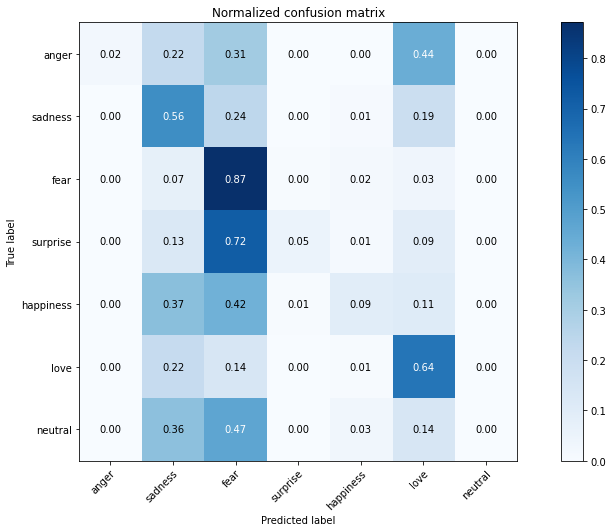

In [ ]:
class_names = ['anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral']

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)


print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Random Forest Classifier

Accuracy: 48.66%

F1 Score: 48.66

COnfusion Matrix:
 [[ 240  128  165    4   90  149    1]
 [  22 1064  294   35  509  282   14]
 [   4  211 1582   78  393  102    5]
 [   2  128  369  316  174   80    6]
 [   6  403  173   45  984   82    6]
 [  20  471  348   18  269 1108    4]
 [   6  180  121   14  163   57   44]]


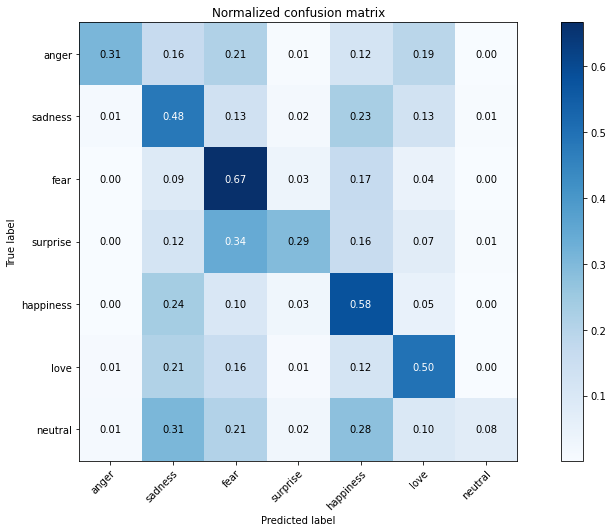

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Logistic Regression 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 54.25%

F1 Score: 54.25

COnfusion Matrix:
 [[ 322  133  101    6   71  143    1]
 [  30 1137  212   41  459  336    5]
 [   4  147 1690   93  357   82    2]
 [   3   93  358  392  163   63    3]
 [   4  360  192   43  988  104    8]
 [  22  446  147   26  213 1381    3]
 [   2  183  125   18  156   60   41]]


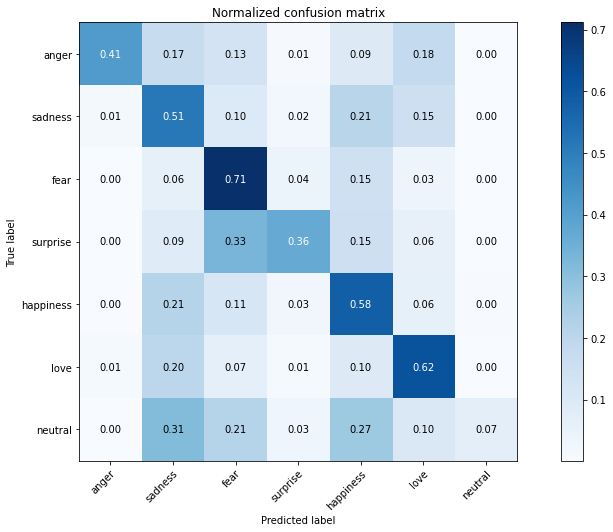

In [ ]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### SVM 

Accuracy: 55.77%

F1 Score: 55.77

COnfusion Matrix:
 [[ 441  125   45    9   57   98    2]
 [  48 1111  186   55  432  360   28]
 [  12  123 1673  143  339   69   16]
 [   7   82  302  477  139   57   11]
 [  13  345  219   63  881  148   30]
 [  45  393  112   44  212 1414   18]
 [   9  146   91   29  146   44  120]]


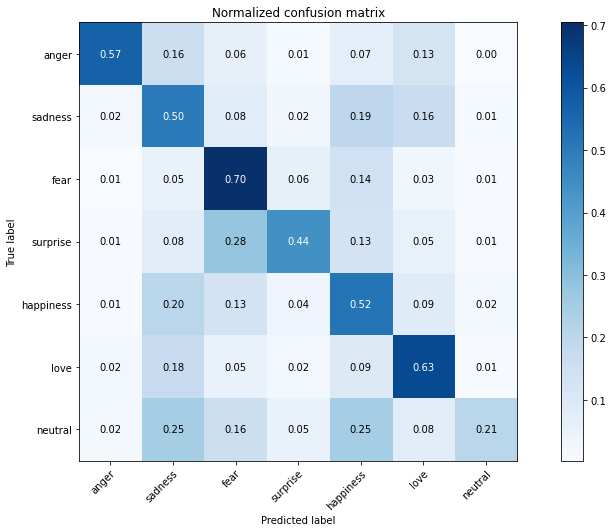

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [ ]:
# save the model
filename = 'tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was damn late and my pizza is cold!' 
model.predict([message])

array(['fear'], dtype=object)

## Emotion Classification in texts using CNN and Word2Vec

####Embedding Layer
Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#####Deep Network
Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position.

#### Fully Connected Layer
The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.
Output Layer
Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.


In [ ]:
# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
# Number of labels: 'anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral'
num_classes = 7

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral']

In [ ]:
def clean_text(data):
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data


texts = [' '.join(clean_text(text)) for text in normalized_df.content]

texts_train = [' '.join(clean_text(text)) for text in x_train]
texts_test = [' '.join(clean_text(text)) for text in x_test]

In [ ]:
print(texts_train[92])

@ mention forget to answer -pron- kindle question yesterday honestly have not use -pron- much have two paperback book i want 2 read first


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(normalized_df.content)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 24151


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    8,   72,  112],
       [   0,    0,    0, ...,    6,   13,   89],
       [   0,    0,    0, ..., 1163,   47, 2035],
       ...,
       [   0,    0,    0, ..., 9853,    1, 3594],
       [   0,    0,    0, ...,   50,    5,  339],
       [   0,    0,    0, ...,    0,    0,    9]], dtype=int32)

In [ ]:
encoding = {
    'anger': 0,
    'sadness': 1,
    'fear': 2,
    'surprise': 3,
    'happiness': 4,
    'love': 5,
    'neutral': 6
}

# Integer labels
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(24152, 300)

In [ ]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 19668
New words found: 4483


In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256
learning_rate=0.1

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
from keras.optimizers import SGD
model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate), metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          7245600   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 7,543,847
Trainable params: 298,247
Non-trainable params: 7,245,600
_________________________________________________________________


In [ ]:
batch_size = 256
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
172/172 [==============================] - 10s 56ms/step - loss: 1.3934 - accuracy: 0.4712 - val_loss: 1.3609 - val_accuracy: 0.4710
Epoch 2/15
172/172 [==============================] - 10s 55ms/step - loss: 1.3167 - accuracy: 0.5096 - val_loss: 1.2953 - val_accuracy: 0.5253
Epoch 3/15
172/172 [==============================] - 10s 55ms/step - loss: 1.2677 - accuracy: 0.5271 - val_loss: 1.2552 - val_accuracy: 0.5315
Epoch 4/15
172/172 [==============================] - 10s 56ms/step - loss: 1.2191 - accuracy: 0.5430 - val_loss: 1.2217 - val_accuracy: 0.5406
Epoch 5/15
172/172 [==============================] - 10s 55ms/step - loss: 1.1848 - accuracy: 0.5558 - val_loss: 1.2594 - val_accuracy: 0.5292
Epoch 6/15
172/172 [==============================] - 9s 55ms/step - loss: 1.1513 - accuracy: 0.5688 - val_loss: 1.1933 - val_accuracy: 0.5556
Epoch 7/15
172/172 [==============================] - 9s 55ms/step - loss: 1.1282 - accuracy: 0.5794 - val_loss: 1.1641 - val_accuracy: 0

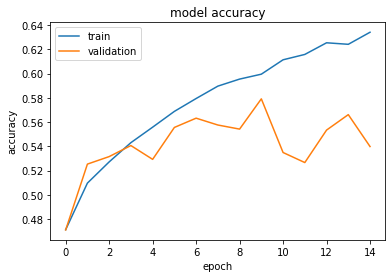

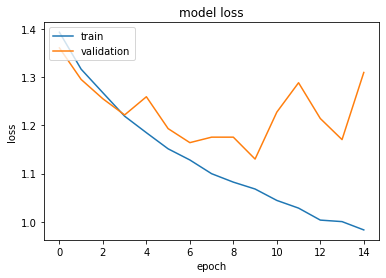

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
y_train.shape

(43875, 7)

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_dataset, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_dataset, predictions, average='micro') * 100))

Accuracy: 53.98%

F1 Score: 53.98


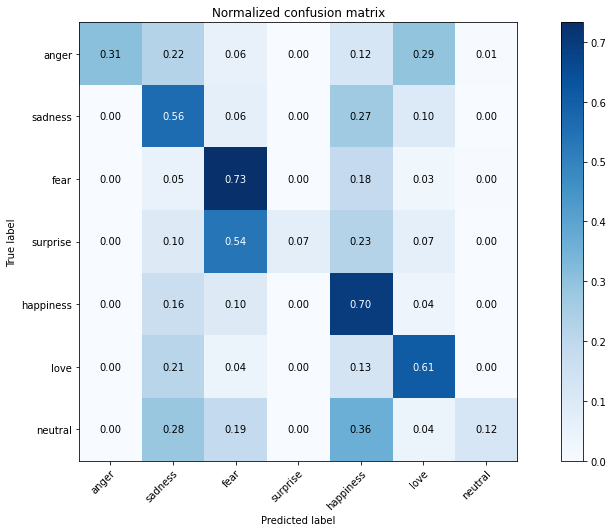

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_dataset, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
print('Message: {}\nPredicted: {}'.format(x_test, predictions))

Message: 376                                 @mention i miss -pron-
3886     no santa cruz for -pron- but -pron- do have an...
31778                  i should not feel altogether mellow
21893    @mention -pron- usually do if there be choice ...
39583    -pron- monitor will not turn on this can only ...
                               ...                        
21703                                   @mention thank ppm
53763    @mention may -pron- please have a couple promo...
53860    good morning just go to bed -pron- feel and al...
30231    i be feel so amused at the man a tone that i t...
34242    take the most amazing power nap every now -pro...
Name: content, Length: 10969, dtype: object
Predicted: ['sadness', 'happiness', 'happiness', 'happiness', 'fear', 'surprise', 'neutral', 'surprise', 'fear', 'sadness', 'happiness', 'neutral', 'fear', 'happiness', 'neutral', 'happiness', 'sadness', 'sadness', 'neutral', 'fear', 'neutral', 'fear', 'neutral', 'neutral', 'neutral', 'neutral', '

In [ ]:
import time

message = ['i am concern, i am going to fail this module!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['i am concern, i am going to fail this module!']
predicted: sadness (0.05 seconds)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          7245600   
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 7,543,847
Trainable params: 298,247
Non-trainable params: 7,245,600
_________________________________________________________________


In [ ]:
batch_size = 256
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
172/172 [==============================] - 10s 57ms/step - loss: 0.9604 - accuracy: 0.6420 - val_loss: 1.1308 - val_accuracy: 0.5819
Epoch 2/15
172/172 [==============================] - 10s 56ms/step - loss: 0.8508 - accuracy: 0.6877 - val_loss: 1.1846 - val_accuracy: 0.5677
Epoch 3/15
172/172 [==============================] - 10s 56ms/step - loss: 0.7397 - accuracy: 0.7352 - val_loss: 1.2888 - val_accuracy: 0.5518
Epoch 4/15
172/172 [==============================] - 10s 56ms/step - loss: 0.6307 - accuracy: 0.7788 - val_loss: 1.3572 - val_accuracy: 0.5474
Epoch 5/15
172/172 [==============================] - 10s 56ms/step - loss: 0.5123 - accuracy: 0.8282 - val_loss: 1.4673 - val_accuracy: 0.5390
Epoch 6/15
172/172 [==============================] - 10s 56ms/step - loss: 0.4147 - accuracy: 0.8642 - val_loss: 1.6281 - val_accuracy: 0.5342
Epoch 7/15
172/172 [==============================] - 10s 56ms/step - loss: 0.3335 - accuracy: 0.8948 - val_loss: 1.7322 - val_accuracy:

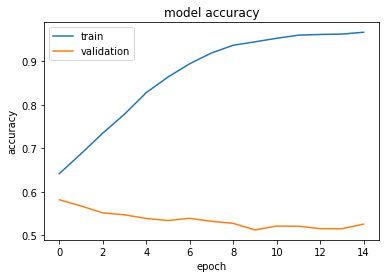

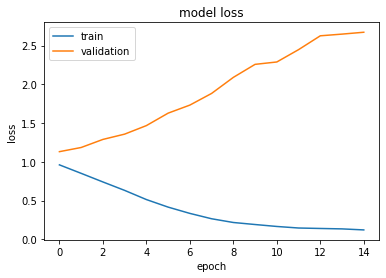

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('cnn_w_Word2Vec.h5')


from keras.models import load_model
predictor = load_model('cnn_w_Word2Vec.h5')

# Emotion Classification in short texts with BERT

In [ ]:
# install ktrain on Google Colab
!pip3 install ktrain

     |████████████████████████████████| 25.3MB 1.5MB/s 
     |████████████████████████████████| 983kB 52.5MB/s 
     |████████████████████████████████| 266kB 50.4MB/s 
     |████████████████████████████████| 1.3MB 56.7MB/s 
     |████████████████████████████████| 471kB 49.6MB/s 
     |████████████████████████████████| 890kB 44.8MB/s 
     |████████████████████████████████| 2.9MB 50.7MB/s 
     |████████████████████████████████| 1.1MB 46.5MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.0-cp36-none-any.whl size=25274500 sha256=3eb71c2f94a62dbfa407593ec6318019a5a0f4de687d6217e3fc4f494f54871c
  Stored in directory: /root/.cache/pip/wheels/5c/73/05/f36d0027bb6575384e21506dbba8db36a7825f15a24f09b2d5
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=9c1e642b2142d1cc9303203120f8556be5c59a39fafc71f487276ca63b661906
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [ ]:
import ktrain
from ktrain import text

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_df['content'], normalized_df['sentiment'], test_size=0.2)
X_train = X_train.to_list()
X_test = X_test.to_list()
Y_test = Y_test.to_list()
Y_train = Y_train.to_list()

In [ ]:
(x_train_bert,  y_train_bert), (x_test_bert, y_test_bert), preproc = text.texts_from_array(x_train=X_train, y_train=Y_train,
                                                                       x_test=X_test, y_test=Y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:588: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


task: text classification


In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), 
                             val_data=(x_test_bert, y_test_bert),
                             batch_size=6)

In [ ]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
7313/7313 [==============================] - 3089s 422ms/step - loss: 1.8526 - accuracy: 0.2166 - val_loss: 1.8521 - val_accuracy: 0.2003
Epoch 2/3
7313/7313 [==============================] - 3091s 423ms/step - loss: 1.8473 - accuracy: 0.2118 - val_loss: 1.8495 - val_accuracy: 0.2164
Epoch 3/3
6657/7313 [==========================>...] - ETA: 4:27 - loss: 1.8444 - accuracy: 0.2163

In [ ]:
learner.validate(val_data=(x_test_bert, y_test_bert), class_names=class_names)

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

In [ ]:
import time 

message = 'I just broke up with my boyfriend'

start_time = time.time() 
prediction = predictor.predict(message)

print('predicted: {} ({:.2f})'.format(prediction, (time.time() - start_time)))

In [ ]:
# let's save the predictor for later use
predictor.save("bert_model")